In [2]:
import numpy as np
import pandas as pd
import pickle
import logging
from typing import Tuple

from tools.analyzer_two_thresh import BaselineOreGrading
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from src.detection.contour_detecting import contour_detection, get_contour_pixels, get_contour_box_image
from src.detection.image_processing import concat_xray_image, split_dual_xray_image, convert_uint16_to_uint8, \
    crop_image, show_image, draw_contours, compensate_xray_image
import os

In [3]:
from importlib import reload
import src.detection.image_processing
reload(src.detection.image_processing)
from src.detection.image_processing import draw_contours

In [91]:
import seaborn as sns

sns.set_context("talk")
sns.set_style("ticks")

In [4]:
from pathlib import Path
from PIL import Image

# Current test on new few stones

In [5]:
# path = "E:/photoelectric_sorting/data/20250212_current_test"
path = "E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/"
# path = "E:/photoelectric_sorting/data/20250218" # 3精3废加 随机的废石
names = sorted(Path(path).iterdir())

In [6]:
names[1:5]

[WindowsPath('E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/160kV_12mA.png'),
 WindowsPath('E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/160kV_16mA.png'),
 WindowsPath('E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/160kV_4mA.png'),
 WindowsPath('E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/160kV_6mA_empty_plastic_lid.png')]

## test the best threshold values for getting contour

In [31]:
def plot_contour_find_th(low, high, current):
    '''current: string; 8mA'''
    
    for th_val in range(100, 140, 10):
        # use lowE to get contours
        contours = contour_detection(low, roi=(None, None, 250, 1236), th_val=th_val)
        # print(len(contours))
        _low = draw_contours(low, contours, thickness=2, show_index=True, indexes=np.arange(len(contours)))
        _high = draw_contours(high, contours, thickness=2, show_index=True, indexes=np.arange(len(contours)))
        image_drawed = np.hstack([_low, _high])
        plt.figure(figsize = (15, 10))
        plt.imshow(image_drawed[250:1236, :])
        plt.title('I = %s, th_val is %s, N is %s, while N_true is 42'%(current, th_val, len(contours)))
        plt.savefig('E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/contour_test//current_%s_test_th_val_%s.jpg'%(current, th_val), format = 'jpg')
        # plt.show()
        plt.close()

for idx, filename in enumerate(names[1:5]):
    image = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
    # image2 = Image.open(filename)
    low, high = split_dual_xray_image(image.T)
    plot_contour_find_th(low, high, filename.name.split('_')[1].split('.')[0])
    # plt.show()

## set th_val = 100

In [ ]:
for idx, filename in enumerate(names[1:5]):
    image = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
    # image2 = Image.open(filename)
    low, high = split_dual_xray_image(image.T)
    th_val = 100
    contours = contour_detection(low, roi=(None, None, 250, 1236), th_val=th_val)
    # print(len(contours))
    _low = draw_contours(low, contours, thickness=2, show_index=True, indexes=np.arange(len(contours)))
    _high = draw_contours(high, contours, thickness=2, show_index=True, indexes=np.arange(len(contours)))
    image_drawed = np.hstack([_low, _high])
    plt.figure(figsize = (15, 15))
    plt.imshow(image_drawed[250:1236, 0:896])
    plt.savefig('E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/contours/contours_dely_110_x_%s.jpg'%filename.name[:-4], format = 'jpg')

    # plt.savefig('E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/contour_test/test_rect_dely_110_x_%s.jpg'%filename.name.split('_')[1].split('.')[0], format = 'jpg')
    # plt.imshow(image_drawed[250:1236:, 0:1664])
    # plt.savefig('E:/photoelectric_sorting/data/20250218/test_rect_dely_105_x_%s.jpg'%filename.name.split('_')[0], format = 'jpg')

plt.close()

## Get values in each contour

In [6]:
names[0:4][0].name[:-4]

'140kV_4mA'

In [14]:
names[0:4][0].name.split('_')

['140kV', '4mA.png']

In [59]:

image_indices_4 = []
image_indices_6 = []
image_indices_8 = []
image_indices_10 = []
image_indices_12 = [1, 23, 39, 14, 35, 22, 17, ]


(1536, 896)

In [8]:
# Step 8: Handing the detection indexes
# rocks_indexes = -np.ones(190, dtype=int)
# for i, num in enumerate(detection_indexes):
#     if num is not None:
#         rocks_indexes[int(num) - 1] = i

for idx, filename in enumerate(names[3:4]):
        image = cv2.imread(filename,cv2.IMREAD_GRAYSCALE)
        # image2 = Image.open(filename)
        low, high = split_dual_xray_image(image.T)
        th_val = 100
        contours = contour_detection(low, roi=(None, None, 250, 1236), th_val=th_val)

        rocks_indexes = np.arange(0, 42)
        # Step 9: Crop the bounding box of each rock
        # contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
        contours = sorted(contours, key=lambda c: ((cv2.boundingRect(c)[1] + cv2.boundingRect(c)[3]) //110, cv2.boundingRect(c)[0]))
        low_rock_images = []
        high_rock_images = []
        low_rock_pixels = []
        high_rock_pixels = []
        for i in range(42):
                contour = contours[rocks_indexes[i]]
                low_rock_images.append(get_contour_box_image(low, contour, margin=10))
                high_rock_images.append(get_contour_box_image(high, contour, margin=10))
                low_rock_pixels.append(get_contour_pixels(low, contour))
                high_rock_pixels.append(get_contour_pixels(high, contour))
                # plt.imshow(low_rock_images[i], cmap = 'gray')
                # plt.axis('off')
                cv2.imwrite('E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/rocks/%s_%s_low.png'%(filename.name.split('.')[0], i), low_rock_images[i])
                cv2.imwrite('E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/rocks/%s_%s_high.png'%(filename.name.split('.')[0], i), high_rock_images[i])

                # plt.close()
                

In [9]:
image.shape

(768, 3072)

In [10]:
names[3]

WindowsPath('E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/160kV_4mA.png')

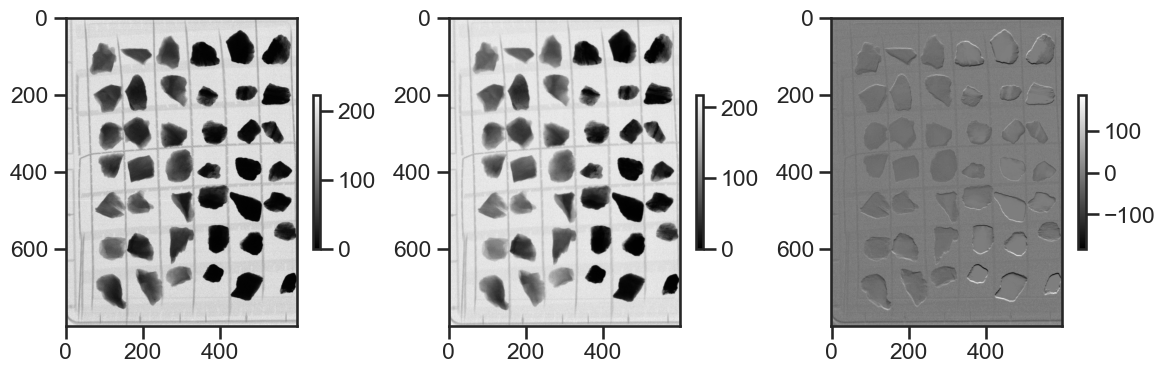

In [95]:
fig, axes = plt.subplots(1,3, figsize=(14,4))
im = axes[0].imshow(low[400:1200, 100:700], cmap = 'gray')
fig.colorbar(im, ax=axes[0], shrink=0.5)
im6 = axes[1].imshow(high[400:1200, 100:700], cmap = 'gray')
fig.colorbar(im6, ax = axes[1], shrink=0.5)

im7 = axes[2].imshow((low.astype(np.int16) - high.astype(np.int16))[400:1200, 100:700], cmap = 'gray')
fig.colorbar(im7, ax = axes[2], shrink=0.5)

plt.show()

In [38]:
def vertical_shift(img, n_pixels):
    n = n_pixels % img.shape[0]  # 处理超出图像高度的位移
    return np.vstack((img[n:], img[:n]))

## test on 错位 between low- and high- energy part 高能和低能在左右（垂直于皮带方向）上偏离2个像素，上下方向偏离1个像素。

In [30]:
test_image = cv2.imread('E:/photoelectric_sorting/data/160kV_3mA_length_test2_None.png', cv2.IMREAD_GRAYSCALE)
test_low, test_high = split_dual_xray_image(test_image.T)
test_low = test_low.astype(np.int16)
test_high = test_high.astype(np.int16)

In [31]:
test_low.dtype

dtype('int16')

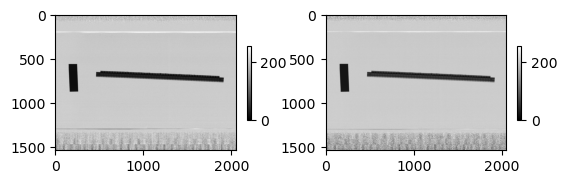

In [32]:
fig, axes = plt.subplots(1,2)
im = axes[0].imshow(test_low, cmap = 'gray')
fig.colorbar(im, ax=axes[0], shrink=0.2)
im6 = axes[1].imshow(test_high, cmap = 'gray')
fig.colorbar(im6, ax = axes[1], shrink=0.2)
plt.show()

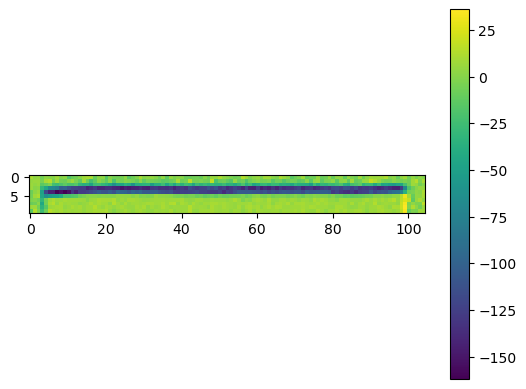

In [35]:
plt.imshow((test_high-test_low)[560:570, 150:255])
plt.colorbar()
plt.show()

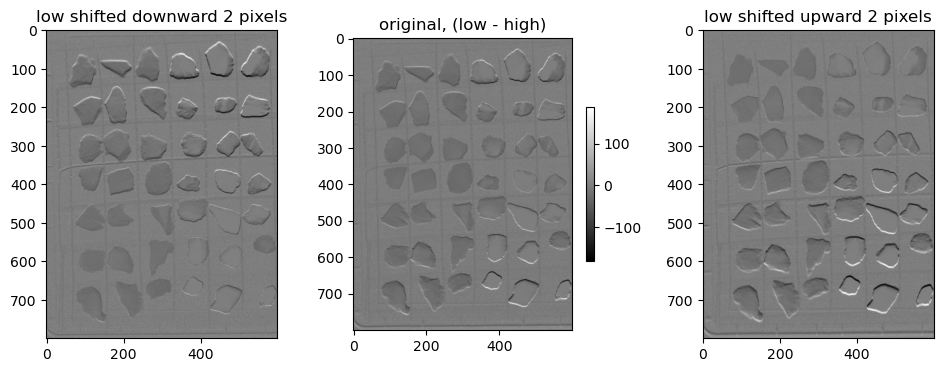

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(12,4))
axes[0].imshow((vertical_shift(low.astype(np.int16),-2) - high.astype(np.int16))[400:1200, 100:700], cmap = 'gray')
axes[0].set_title('low shifted downward 2 pixels')
im = axes[1].imshow((vertical_shift(low.astype(np.int16),0) - high.astype(np.int16))[400:1200, 100:700], cmap = 'gray')
fig.colorbar(im, ax=axes[1], shrink = 0.5)
axes[1].set_title('original, (low - high)')
axes[2].imshow((vertical_shift(low.astype(np.int16),2) - high.astype(np.int16))[400:1200, 100:700], cmap = 'gray')
axes[2].set_title('low shifted upward 2 pixels')
plt.show()

## Test 纸壳子和塑料壳子的吸收

- test the impact on intensity of 纸壳子（和蓝色的塑料壳子）
- 160kV_4mA, 用纸盒的盖子代替纸盒的底部
- low energy part w/o paper: 203.19537974683544 3.8537324751466597 (mean and std)
- high energy part w/o paper: 203.1051 3.8537324751466597
- low energy part with paper lid: 199.36807775768534 6.125897373729779
- high energy part with paper lid: 200.54247142857142 3.8767087153240425

- test of plastic 壳子
- 160kV_6mA_empty_plastic_lid.png
- low energy part with plastic: 196.8114857142857 4.527330915807291
- high energy part with plastic 205.76848 3.095835669023794

In [126]:
im_plastic[100:200, 500:1000].mean()

206.29256

In [124]:
im_plastic = cv2.imread("E:/photoelectric_sorting/data/20250217_three_columns_good_three_columns_bad/160kV_6mA_empty_plastic_lid.png", cv2.IMREAD_GRAYSCALE)

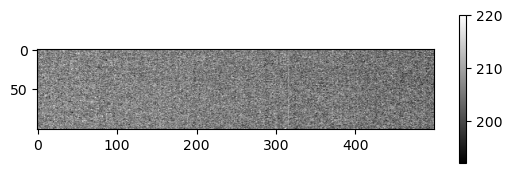

In [128]:
im4 = plt.imshow(im_plastic[100:200, 2000:2500], cmap='gray')
plt.colorbar(im4, shrink = 0.4)
plt.show()

In [129]:
print('low energy part with plastic:', im_plastic[400:750, 500:1000].mean(), im_plastic[400:750, 500:1000].std())
print('high energy part with plastic', im_plastic[100:200, 2000:2500].mean(), im_plastic[100:200, 2000:2500].std())

low energy part with plastic: 196.8114857142857 4.527330915807291
high energy part with plastic 205.76848 3.095835669023794


In [93]:
im_paper = cv2.imread("E:/photoelectric_sorting/data/20250219/160kV_4mA_forward.png", cv2.IMREAD_GRAYSCALE)

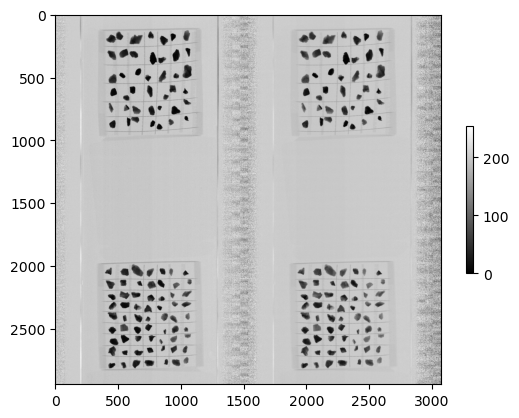

In [107]:
im3 = plt.imshow(im_paper, cmap='gray')
plt.colorbar(im3, shrink = 0.4)
plt.show()

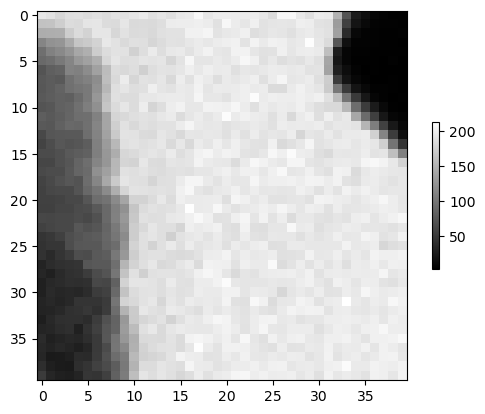

In [106]:
im3 = plt.imshow(im_paper[480:520, 480:520], cmap='gray')
plt.colorbar(im3, shrink = 0.4)
plt.show()

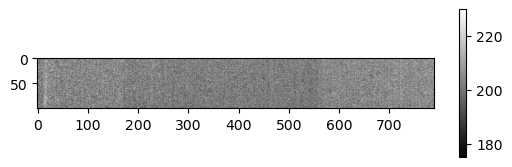

In [94]:
im3 = plt.imshow(im_paper[0:100, 210:1000], cmap='gray')
plt.colorbar(im3, shrink = 0.4)
plt.show()

In [89]:
print('low energy part w/o paper:', im_paper[0:100, 210:1000].mean(), im_paper[0:100, 2000:2500].std())
print('high energy part w/o paper:', im_paper[0:100, 2000:2500].mean(), im_paper[0:100, 2000:2500].std())

print('low energy part with paper lid:', im_paper[1100:1800, 210:1000].mean(), im_paper[1100:1800, 200:1000].std())
print('high energy part with paper lid:', im_paper[1100:1800, 2000:2500].mean(), im_paper[1100:1800, 2000:2500].std())

low energy part w/o paper: 203.19537974683544 3.8537324751466597
high energy part w/o paper: 203.1051 3.8537324751466597
low energy part with paper lid: 199.36807775768534 6.125897373729779
high energy part with paper lid: 200.54247142857142 3.8767087153240425


## find initial intensity ($I_0$)

- $I_0(160kV\_4mA)(low\_energy) = 195$
- $I_0(160kV\_4mA) (high\_energy) = 196$

In [104]:
low[820:840, 170:240].mean()

194.63071428571428

In [48]:
low[1210:1280, :].mean()

low[220:300, :].mean()

low_rock_images[1][0:20, 0:20].mean()

203.13911830357142

In [145]:
high_rock_images[0][0:20, 0:20].mean()

196.21

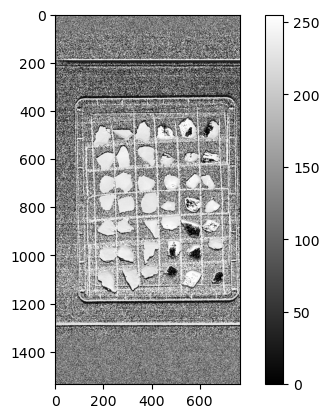

In [151]:
plt.imshow((low - high), cmap = 'gray')
plt.colorbar()
plt.show()

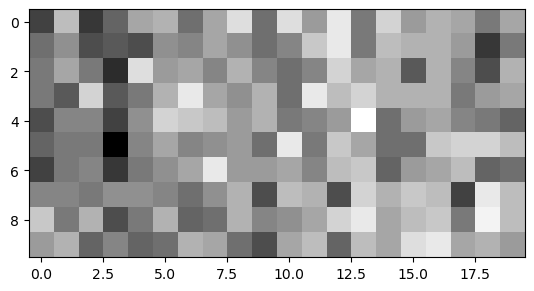

In [140]:
high_rock_images[0][0:10, 0:20].mean()
plt.imshow(high_rock_images[0][0:10, 0:20], cmap='gray')
plt.show()

In [9]:
len(low_rock_pixels[0])

3250

In [10]:
len(high_rock_pixels[0])

3250

## R-values

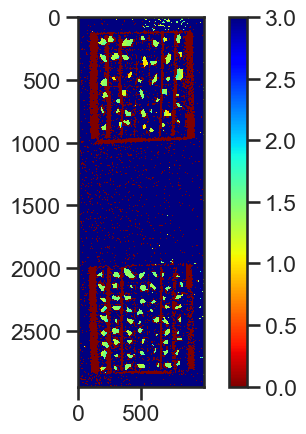

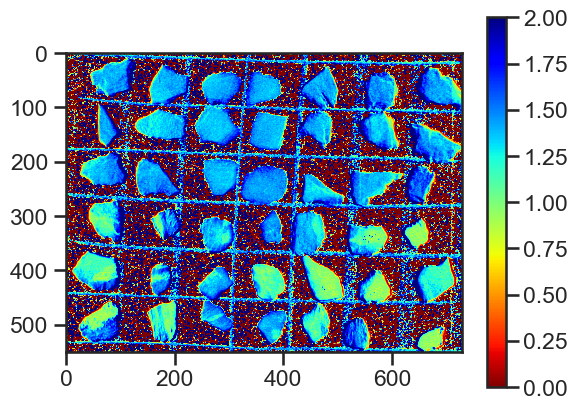

In [63]:
len(high_rock_images)

42

# Trial on original 190 stones

In [92]:
img = concat_xray_image('E:/photoelectric_sorting/data/20240822_190块矿石实验_原始图像/output1', axis=0) # 12mA

In [93]:
img.shape

(44672, 3072)

In [116]:
# belt = crop_image(img, x1x2y1y2=(None, None, 100, 7500))
img_cropped = crop_image(img.T, x1x2y1y2=(26100, 32500, None, None))
print(img_cropped.dtype)
img_cropped_8 = convert_uint16_to_uint8(img_cropped)
print(img_cropped_8.dtype)

uint16
uint8


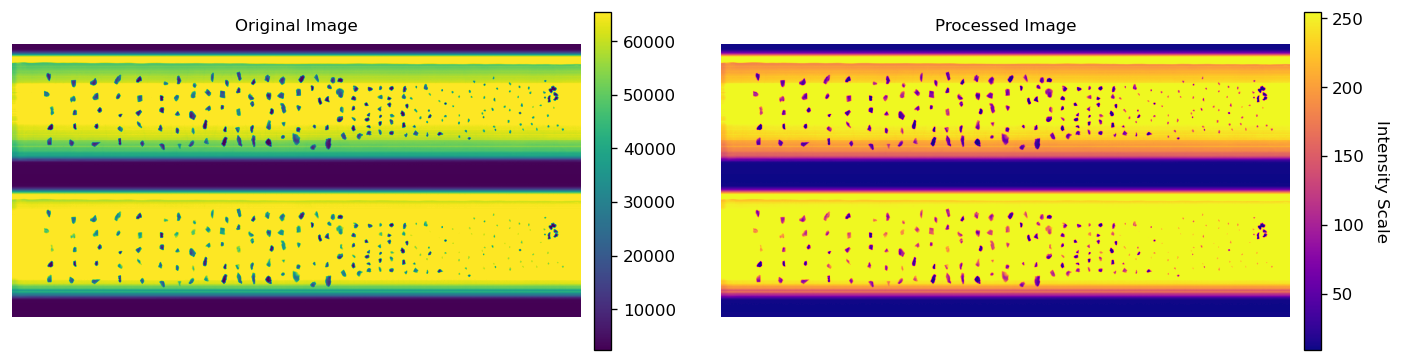

In [126]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), dpi=120)

# 第一个子图配置
im1 = ax1.imshow(img_cropped, cmap='viridis')  # 推荐显式指定colormap
ax1.set_title('Original Image', fontsize=10, pad=8)
ax1.axis('off')  # 隐藏坐标轴
fig.colorbar(im1, ax=ax1, orientation='vertical', shrink=0.6, pad=0.02)

# 第二个子图配置
im2 = ax2.imshow(img_cropped_8, cmap='plasma')  # 使用不同colormap增强区分度
ax2.set_title('Processed Image', fontsize=10, pad=8)
ax2.axis('off')
cb2 = fig.colorbar(im2, ax=ax2, orientation='vertical', shrink=0.6, pad=0.02)
cb2.set_label('Intensity Scale', rotation=270, labelpad=15)  # 添加colorbar标签

# 全局优化
plt.subplots_adjust(wspace=0.3)  # 控制子图间距
# plt.suptitle('Image Comparison', y=1.02, fontsize=12, weight='bold')  # 主标题
plt.tight_layout()
plt.show()


In [127]:
low_img, high_img = split_dual_xray_image(img_cropped_8)

In [129]:
low_img.dtype

dtype('uint8')

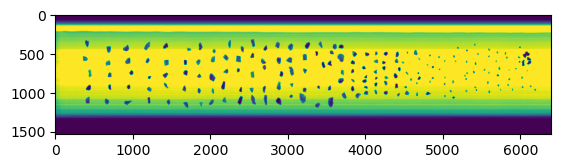

In [130]:
plt.imshow(low_img)
plt.show()

In [132]:
detection_indices = np.array([4, 5, 1, 2, 3, 6, 9, 10, 8, 7, 15, 11, 14, 12, 13, 20, 19, 17, 16, 18, 23, 25, 22, 24, 21, 27, 26, 28, 29, 30,
         34, 33, 32, 35, 31, 36, 38, 39, 37, 40, 42, 41, 44, 43, 45, 49, 48, 46, 47, 50, 52, 54, 53, 51, 55, 59, 58, 57,
         60, 56, 65, 61, 62, 64, 63, 69, 70, 68, 66, 67, 71, 74, 72, 73, 75, 76, 79, 77, 80, 78, 83, 81, 82, 84, 85, 89,
         87, 90, 88, 86, 95, 93, 92, 94, 96, 91, 101, 99, 97, 98, 100, 102, 107, 106, 103, 104, 108, 105, 112, 113, 114,
         109, 110, 111, 117, 119, 116, 120, 115, 118, 125, 122, 121, 124, 126, 123, 132, 127, 128, 130, 129, 131, 133,
         137, 134, 138, 135, 136, 144, 142, 140, 143, 139, 141, 146, 145, 147, 149, 148, 150, 153, 152, 151, 155, 156,
         154, 159, 162, 158, 160, 157, 161, 166, 164, 165, 167, 168, 163, 173, 174, 171, 170, 172, 169, 180, 179, 176,
         177, 178, 175, 183, 185, 184, 186, 182, 181, None, None, None, 190, None, 189, 187])

In [156]:
contours = contour_detection(low_img, roi=(None, None, 250, 1236), th_val=254)
_low_img = draw_contours(low_img, contours, thickness=2, show_index=True, indexes=detection_indices)
# _high_img = draw_contours(high_img, contours, thickness=2, show_index=True, indexes=detection_indexes)
# image_drawed = np.vstack([_low_img, _high_img])

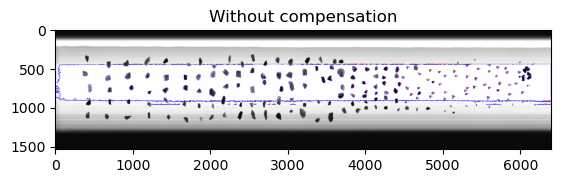

In [157]:
plt.imshow(_low_img)
plt.title('Without compensation')
plt.show()

In [ ]:
detection_params_18 = {
    'image_path': r'/home/jtjt/projects/project_x_ray_images_stack/data/20240822_190块标准矿石样品3组实验/20240822_160_18',
    'crop_params': (20700, 28000, None, None), 'belt_crop': (None, None, 100, 7500, ),
    'roi': (None, None, 250, 1216), 'contour_params': {'th_val': 254}, # 'th_val1': 254, 'min_area1': 50, # 'th_val2': 254, 'min_area2': 50,
    'detection_indexes': np.array(
        [9, 35, 45, 30, 85, 88, 22, 63, 11, 67, 49, 59, 18, 55, 8, 82, 52, 31, 39, 65, 81, 28, 83, 64, 50, 40, 32, 27,
         2, 51, 16, 66, 15, 77, 60, 75, 79, 62, 86, 34, 26, 89, 10, 69, 24, 4, 56, 3, 76, 7, 43, 17, 73, 54, 48, 29, 21,
         6, 84, 53, 20, 46, 42, 23, 74, 41, 37, 57, 70, 12, 1, 13, 14, 5, 61, 47, None, 33, 72, None, 80, 38, 19, 25,
         87, 125, 114, 93, 178, 190, 167, 175, 181, 135, 139, 131, 170, 189, 160, 179, 187, 142, 150, 119, 121, 168,
         163, 158, 169, 95, 117, 104, 109, 180, 154, 173, 157, 144, 145, 103, 143, 110, 185, 151, 155, 123, 112, 127,
         115, 129, 94, 166, 182, 132, 99, 137, 101, 147, 177, 186, 172, 140, 141, 100, 116, 102, 128, 108, 164, 118,
         134, 105, 111, 184, 153, 174, 90, 176, 136, 171, 156, 91, 130, 97, 138, 159, 96, 161, 92, 149, 98, 113, 133,
         120, 183, 165, 152, 124, 122, 126, 106, 146, 148, 107, 162, 44, 36, 58, 68, 78, None, None, None, None])}

In [ ]:
def process_xray_image(image_path, crop_params, roi, contour_params, detection_indexes, belt_crop):
    # Step 1: Concatenate x-ray image
    img = concat_xray_image(image_path, axis=0)  # Axis is hardcoded as 0
    # show_image(img)

    # Step 2: Compensate the xray image using base intensity and empty belt intensity
    base_intensity = pd.read_csv("../data/base intensity/20240606_190kv_4.5mA_column/不开射线源_column.csv")
    base_intensity = base_intensity.Average.values
    belt_img = crop_image(img, belt_crop)
    # show_image(belt_img)
    ori_img = img.copy()
    img = compensate_xray_image(img, belt_intensity=belt_img, base_intensity=base_intensity)
    img = img.T
    ori_img = ori_img.T

    # Step 3: Crop the image based on provided parameters
    img = crop_image(img, x1x2y1y2=crop_params)
    img = convert_uint16_to_uint8(img)
    ori_img = crop_image(ori_img, x1x2y1y2=crop_params)
    ori_img = convert_uint16_to_uint8(ori_img)
    # show_image(img)

    # Step 4: Split the x-ray image into low and high images
    low_img, high_img = split_dual_xray_image(img)

    # # Step 5: Detect and draw contours with the given parameters
    # contours1 = contour_detection(low_img, th_val=contour_params['th_val1'],
    #                               min_contour_area=contour_params['min_area1'])
    # # image1 = draw_contours(low_img, contours1, thickness=-1)
    # # show_image(image1)
    #
    # contours2 = contour_detection(low_img, th_val=contour_params['th_val2'],
    #                               min_contour_area=contour_params['min_area2'])
    # # image2 = draw_contours(low_img, contours2, thickness=-1)
    # # show_image(image2)
    #
    # # Step 6: Combine both sets of contours and process
    # combined_image = np.zeros(low_img.shape, np.uint8)
    # combined_image = cv2.drawContours(combined_image, contours1, -1, (255, 255, 255), thickness=-1)
    # combined_image = cv2.drawContours(combined_image, contours2, -1, (255, 255, 255), thickness=-1)
    #
    # # Step 7: Detect combined contours and visualize
    # contours = contour_detection(combined_image, th_val=254, min_contour_area=50)
    # final_image = draw_contours(low_img, contours, thickness=2, show_index=True)
    # # show_image(final_image)

    # Step 567: Detect and draw contours with the given parameters
    contours = contour_detection(low_img, roi=roi, **contour_params)
    _low_img = draw_contours(low_img, contours, thickness=2, show_index=True, indexes=detection_indexes)
    _high_img = draw_contours(high_img, contours, thickness=2, show_index=True, indexes=detection_indexes)
    image_drawed = np.vstack([_low_img, _high_img])

    # Step 8: Handing the detection indexes
    rocks_indexes = -np.ones(190, dtype=int)
    for i, num in enumerate(detection_indexes):
        if num is not None:
            rocks_indexes[int(num) - 1] = i

    # Step 9: Crop the bounding box of each rock
    contours = sorted(contours, key=lambda c: cv2.boundingRect(c)[0])
    low_rock_images = []
    high_rock_images = []
    low_rock_pixels = []
    high_rock_pixels = []
    for i in range(190):
        if rocks_indexes[i] != -1:
            contour = contours[rocks_indexes[i]]
            low_rock_images.append(get_contour_box_image(low_img, contour, margin=10))
            high_rock_images.append(get_contour_box_image(high_img, contour, margin=10))
            low_rock_pixels.append(get_contour_pixels(low_img, contour))
            high_rock_pixels.append(get_contour_pixels(high_img, contour))
        else:
            low_rock_images.append(None)
            high_rock_images.append(None)
            low_rock_pixels.append(None)
            high_rock_pixels.append(None)
    return image_drawed, low_rock_images, high_rock_images, low_rock_pixels, high_rock_pixels


# Call the process function for the first set of parameters
image6, low_rock_images6, high_rock_images6, low_rock_pixels6, high_rock_pixels6 = process_xray_image(
    **detection_params_6)
image12, low_rock_images12, high_rock_images12, low_rock_pixels12, high_rock_pixels12 = process_xray_image(
    **detection_params_12)
image18, low_rock_images18, high_rock_images18, low_rock_pixels18, high_rock_pixels18 = process_xray_image(
    **detection_params_18)

# # Compare the results by visualizing the final images
# for i, (rock6, rock12, rock18) in enumerate(zip(low_rock_images6, low_rock_images12, low_rock_images18)):
#     if rock6 is not None and rock12 is not None and rock18 is not None:
#         max_height = max(img.shape[0] for img in [rock6, rock12, rock18])
#         max_width = sum(img.shape[1] for img in [rock6, rock12, rock18])
#         combined_image = np.hstack(
#             [np.pad(img, ((0, max_height - img.shape[0]), (0, 0)), mode='constant') for img in [rock6, rock12, rock18]])
#         plt.imshow(combined_image, cmap='gray')
#         plt.title(f'Rock {i + 1}')
#         plt.axis('off')
#         plt.show()

# # Save images
# os.makedirs('160kV_6mA/low', exist_ok=True)
# os.makedirs('160kV_6mA/high', exist_ok=True)
# os.makedirs('160kV_12mA/low', exist_ok=True)
# os.makedirs('160kV_12mA/high', exist_ok=True)
# os.makedirs('160kV_18mA/low', exist_ok=True)
# os.makedirs('160kV_18mA/high', exist_ok=True)
# for i, (low_rock6, low_rock12, low_rock18, high_rock6, high_rock12, high_rock18) in enumerate(
#         zip(low_rock_images6, low_rock_images12, low_rock_images18, high_rock_images6, high_rock_images12,
#             high_rock_images18)):
#     if low_rock6 is not None:
#         cv2.imwrite(f'160kV_6mA/low/rock_{i + 1}.png', low_rock6)
#         cv2.imwrite(f'160kV_6mA/high/rock_{i + 1}.png', high_rock6)
#     if low_rock12 is not None:
#         cv2.imwrite(f'160kV_12mA/low/rock_{i + 1}.png', low_rock12)
#         cv2.imwrite(f'160kV_12mA/high/rock_{i + 1}.png', high_rock12)
#     if low_rock18 is not None:
#         cv2.imwrite(f'160kV_18mA/low/rock_{i + 1}.png', low_rock18)
#         cv2.imwrite(f'160kV_18mA/high/rock_{i + 1}.png', high_rock18)

# # Save the pixel values in a single pickle file, including 6mA, 12mA, 18mA, low and high
# pixel_data = {
#     '6mA': {
#         'low_pixels': low_rock_pixels6,
#         'high_pixels': high_rock_pixels6
#     },
#     '12mA': {
#         'low_pixels': low_rock_pixels12,
#         'high_pixels': high_rock_pixels12
#     },
#     '18mA': {
#         'low_pixels': low_rock_pixels18,
#         'high_pixels': high_rock_pixels18
#     }
# }
# with open('240822_190rock_pixel_values.pkl', 'wb') as f:
#     pickle.dump(pixel_data, f)

print('The End')